YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


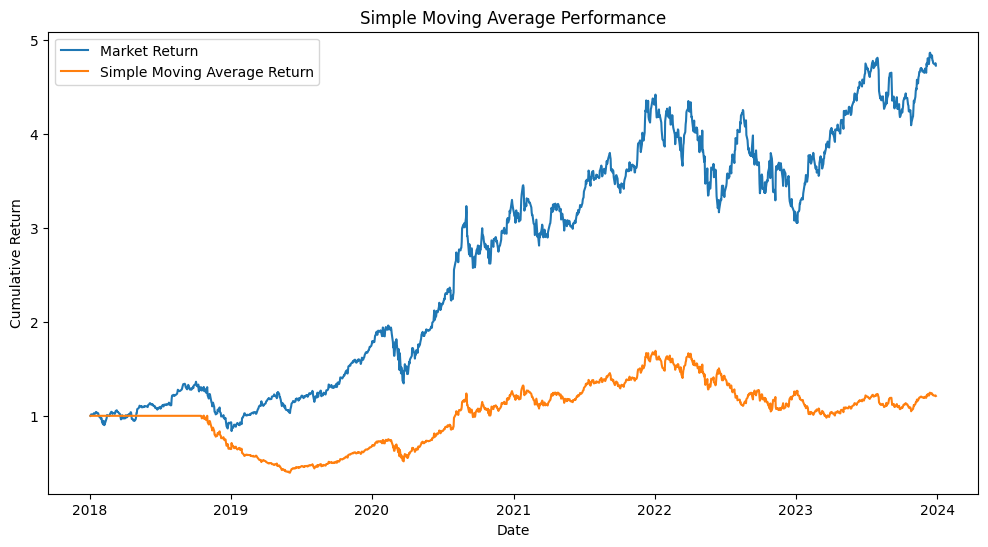


Simple Moving Average Performance:
Total Market Return: 372.78%
Total Strategy Return: 21.11%
Annualized Strategy Return: 3.25%
Sharpe Ratio: 0.19


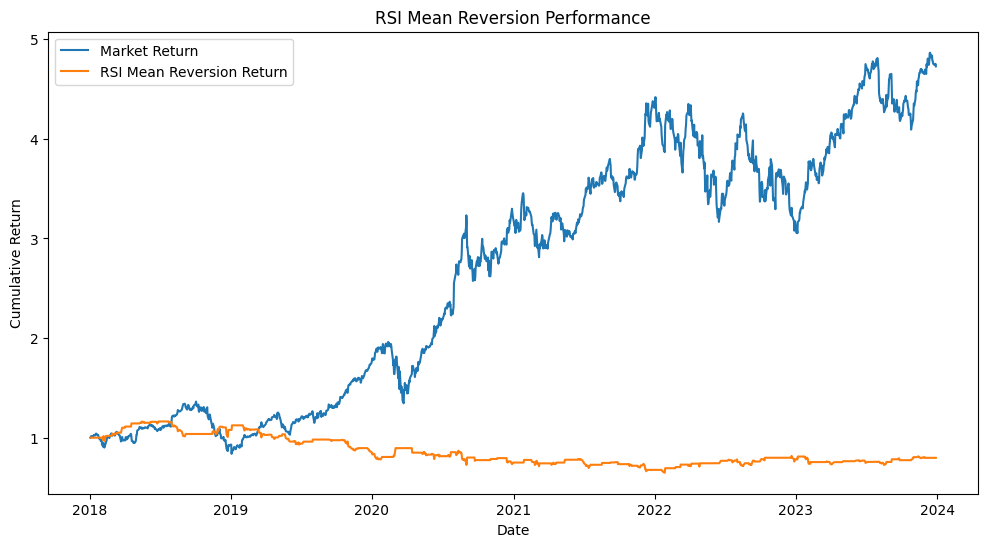


RSI Mean Reversion Performance:
Total Market Return: 372.78%
Total Strategy Return: -20.23%
Annualized Strategy Return: -3.71%
Sharpe Ratio: -0.29


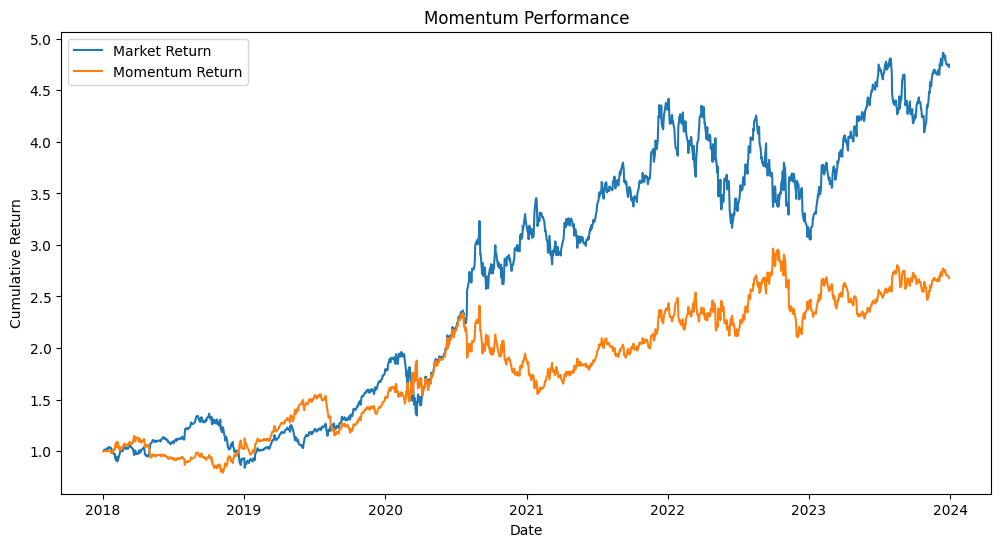


Momentum Performance:
Total Market Return: 372.78%
Total Strategy Return: 167.80%
Annualized Strategy Return: 17.88%
Sharpe Ratio: 0.62

Best Strategy: Momentum
Annual Return: 17.88%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

class StockBacktester:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital

    def fetch_stock_data(self, symbol, start_date, end_date):
        """
        Fetch stock data with error handling
        """
        try:
            data = yf.download(symbol, start=start_date, end=end_date)
            if data.empty:
                print(f"No data available for {symbol}")
                return None
            return data
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def simple_moving_average_strategy(self, data, short_window=50, long_window=200):
        """
        Simple Moving Average Crossover Strategy
        """
        data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
        data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

        data['Signal'] = 0
        data.loc[data['Short_MA'] > data['Long_MA'], 'Signal'] = 1
        data.loc[data['Short_MA'] < data['Long_MA'], 'Signal'] = -1

        data['Returns'] = data['Close'].pct_change()
        data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']

        data['Cumulative_Market_Return'] = (1 + data['Returns']).cumprod()
        data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Returns']).cumprod()

        return data

    def rsi_strategy(self, data, rsi_period=14, lower_threshold=30, upper_threshold=70):
        """
        RSI (Relative Strength Index) Mean Reversion Strategy
        """
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
        rs = gain / (loss + 1e-10)
        data['RSI'] = 100 - (100 / (1 + rs))

        data['Signal'] = 0
        data.loc[data['RSI'] < lower_threshold, 'Signal'] = 1
        data.loc[data['RSI'] > upper_threshold, 'Signal'] = -1

        data['Returns'] = data['Close'].pct_change()
        data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']

        data['Cumulative_Market_Return'] = (1 + data['Returns']).cumprod()
        data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Returns']).cumprod()

        return data

    def momentum_strategy(self, data, lookback_period=12):
        """
        Simple Momentum Strategy
        """
        data['Momentum'] = data['Close'].pct_change(lookback_period)

        data['Signal'] = 0
        data.loc[data['Momentum'] > 0, 'Signal'] = 1
        data.loc[data['Momentum'] < 0, 'Signal'] = -1

        data['Returns'] = data['Close'].pct_change()
        data['Strategy_Returns'] = data['Signal'].shift(1) * data['Returns']

        data['Cumulative_Market_Return'] = (1 + data['Returns']).cumprod()
        data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Returns']).cumprod()

        return data

    def analyze_strategy_performance(self, data, strategy_name):
        """
        Analyze and visualize strategy performance
        """
        total_market_return = data['Cumulative_Market_Return'].iloc[-1] - 1
        total_strategy_return = data['Cumulative_Strategy_Return'].iloc[-1] - 1
        annual_strategy_return = (1 + total_strategy_return) ** (252 / len(data)) - 1

        risk_free_rate = 0.02
        strategy_returns = data['Strategy_Returns'].dropna()
        sharpe_ratio = (strategy_returns.mean() * 252 - risk_free_rate) / (strategy_returns.std() * np.sqrt(252))

        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data['Cumulative_Market_Return'], label='Market Return')
        plt.plot(data.index, data['Cumulative_Strategy_Return'], label=f'{strategy_name} Return')
        plt.title(f'{strategy_name} Performance')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.show()

        print(f"\n{strategy_name} Performance:")
        print(f"Total Market Return: {total_market_return*100:.2f}%")
        print(f"Total Strategy Return: {total_strategy_return*100:.2f}%")
        print(f"Annualized Strategy Return: {annual_strategy_return*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        return {
            'total_market_return': total_market_return,
            'total_strategy_return': total_strategy_return,
            'annual_strategy_return': annual_strategy_return,
            'sharpe_ratio': sharpe_ratio
        }

def main():
    backtester = StockBacktester(initial_capital=10000)

    stock = 'AAPL'
    start_date = '2018-01-01'
    end_date = '2023-12-31'

    stock_data = backtester.fetch_stock_data(stock, start_date, end_date)

    if stock_data is not None:
        strategies = [
            ('Simple Moving Average', backtester.simple_moving_average_strategy),
            ('RSI Mean Reversion', backtester.rsi_strategy),
            ('Momentum', backtester.momentum_strategy)
        ]

        results = {}
        for name, strategy_func in strategies:
            strategy_data = strategy_func(stock_data.copy())
            performance = backtester.analyze_strategy_performance(strategy_data, name)
            results[name] = performance

        best_strategy = max(results, key=lambda x: results[x]['annual_strategy_return'])
        print(f"\nBest Strategy: {best_strategy}")
        print(f"Annual Return: {results[best_strategy]['annual_strategy_return']*100:.2f}%")

if __name__ == "__main__":
    main()


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class RobustBacktester:
    def __init__(self, symbol='AAPL', initial_capital=10000):
        self.symbol = symbol
        self.initial_capital = float(initial_capital)
        self.data = None

    def fetch_data(self, start_date, end_date):
        """Fetch and preprocess stock data."""
        try:
            df = yf.download(self.symbol, start=start_date, end=end_date, progress=False)
            if df.empty:
                raise ValueError(f"No data available for {self.symbol}")

            # Keep only relevant columns and compute indicators
            df = df[['Open', 'High', 'Low', 'Close']].copy()
            df['SMA_20'] = df['Close'].rolling(window=20).mean()
            df['SMA_50'] = df['Close'].rolling(window=50).mean()
            df['RSI'] = self._calculate_rsi(df['Close'])
            df['MACD'] = self._calculate_macd(df['Close'])
            df['Upper_BB'], df['Lower_BB'] = self._calculate_bollinger_bands(df['Close'])
            df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()
            df.dropna(inplace=True)

            self.data = df
        except Exception as e:
            print(f"Data fetching error: {e}")

    def _calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / (loss + 1e-10)
        return 100.0 - (100.0 / (1.0 + rs))

    def _calculate_macd(self, series, slow=26, fast=12, signal=9):
        ema_fast = series.ewm(span=fast, adjust=False).mean()
        ema_slow = series.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        return macd_line.ewm(span=signal, adjust=False).mean()

    def _calculate_bollinger_bands(self, series, window=20, num_std=2):
        sma = series.rolling(window=window).mean()
        std = series.rolling(window=window).std()
        upper_band = sma + (std * num_std)
        lower_band = sma - (std * num_std)
        return upper_band, lower_band

    def enhanced_momentum_strategy(self):
        """Enhanced momentum strategy."""
        # Get necessary series from the data
        close = self.data['Close']
        sma_50 = self.data['SMA_50']
        rsi = self.data['RSI']
        pct_change_20 = close.pct_change(20).fillna(0)

        # Align all series to ensure indices match
        close, sma_50 = close.align(sma_50, axis=0)
        close, rsi = close.align(rsi, axis=0)
        close, pct_change_20 = close.align(pct_change_20, axis=0)

        signals = ((close > sma_50) & (rsi > 50) & (pct_change_20 > 0.05)).astype(int)
        return signals

    def mean_reversion_strategy(self):
        """Mean reversion strategy."""
        close = self.data['Close']
        lower_bb = self.data['Lower_BB']
        rsi = self.data['RSI']

        # Align series to ensure proper element-wise comparisons
        close, lower_bb = close.align(lower_bb, axis=0)
        close, rsi = close.align(rsi, axis=0)

        signals = ((close < lower_bb) & (rsi < 30)).astype(int)
        return signals

    def adaptive_trend_strategy(self):
        """Adaptive trend strategy."""
        close = self.data['Close']
        macd = self.data['MACD']
        sma_20 = self.data['SMA_20']
        volatility = self.data['Volatility']

        # Calculate moving average of volatility and align series
        vol_ma = volatility.rolling(50).mean().fillna(volatility.mean())
        close, sma_20 = close.align(sma_20, axis=0)
        macd, _ = macd.align(close, axis=0)
        volatility, vol_ma = volatility.align(vol_ma, axis=0)

        signals = ((macd > 0) & (close > sma_20) & (volatility < vol_ma)).astype(int)
        return signals

    def run_backtest(self, strategy_func, stop_loss=0.95, take_profit=1.10):
        # Create a working copy of the data and generate signals
        df = self.data.copy()
        df['Signal'] = strategy_func()

        # Initialize portfolio DataFrame
        portfolio = pd.DataFrame(index=df.index,
                                 columns=['Cash', 'Shares', 'Total', 'Trade_Type'],
                                 dtype=object)
        portfolio.iloc[0] = [self.initial_capital, 0, self.initial_capital, 'Hold']

        position = 0
        entry_price = 0

        for i in range(1, len(df)):
            # Carry forward previous portfolio state
            portfolio.iloc[i] = portfolio.iloc[i-1].copy()
            current_price = df['Close'].iloc[i]
            signal = df['Signal'].iloc[i]

            if position == 0 and signal == 1:
                shares = int(portfolio['Cash'].iloc[i] / current_price)
                if shares > 0:
                    entry_price = current_price
                    portfolio.at[df.index[i], 'Shares'] = shares
                    portfolio.at[df.index[i], 'Cash'] -= shares * current_price
                    portfolio.at[df.index[i], 'Trade_Type'] = 'Long Entry'
                    position = 1
            elif position == 1:
                stop_loss_price = entry_price * stop_loss
                take_profit_price = entry_price * take_profit
                if (current_price <= stop_loss_price) or (current_price >= take_profit_price):
                    portfolio.at[df.index[i], 'Cash'] += portfolio['Shares'].iloc[i] * current_price
                    portfolio.at[df.index[i], 'Shares'] = 0
                    portfolio.at[df.index[i], 'Trade_Type'] = 'Exit'
                    position = 0

            # Update portfolio total value
            portfolio.at[df.index[i], 'Total'] = (portfolio['Cash'].iloc[i] +
                                                  portfolio['Shares'].iloc[i] * current_price)

        # Convert columns to appropriate types
        portfolio['Cash'] = portfolio['Cash'].astype(float)
        portfolio['Shares'] = portfolio['Shares'].astype(int)
        portfolio['Total'] = portfolio['Total'].astype(float)

        return portfolio

    def run_all_strategies(self, start_date, end_date):
        self.fetch_data(start_date, end_date)
        strategies = {
            'Enhanced Momentum': self.enhanced_momentum_strategy,
            'Mean Reversion': self.mean_reversion_strategy,
            'Adaptive Trend': self.adaptive_trend_strategy
        }
        portfolios = {}
        results = {}

        for name, strategy in strategies.items():
            portfolio = self.run_backtest(strategy)
            portfolios[name] = portfolio
            total_return = (portfolio['Total'].iloc[-1] / self.initial_capital - 1) * 100
            annual_return = total_return * (252 / len(portfolio))
            results[name] = {
                'Final Portfolio Value': portfolio['Total'].iloc[-1],
                'Total Return (%)': total_return,
                'Annualized Return (%)': annual_return
            }
            print(f"\n{name} Strategy Results:")
            for metric, value in results[name].items():
                print(f"{metric}: {value:.2f}")
        return portfolios, results

    def plot_performance(self, portfolios):
        plt.figure(figsize=(12, 6))
        for name, portfolio in portfolios.items():
            plt.plot(portfolio.index, portfolio['Total'], label=name)
        plt.title(f'{self.symbol} Strategy Performance')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def main():
    backtester = RobustBacktester(symbol='AAPL', initial_capital=10000)
    try:
        portfolios, results = backtester.run_all_strategies('2022-01-01', '2024-03-28')
        backtester.plot_performance(portfolios)
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


An error occurred: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.


Traceback (most recent call last):
  File "<ipython-input-2-1349ed33ad26>", line 186, in main
    portfolios, results = backtester.run_all_strategies('2022-01-01', '2024-03-28')
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-1349ed33ad26>", line 157, in run_all_strategies
    portfolio = self.run_backtest(strategy)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-1349ed33ad26>", line 101, in run_backtest
    df['Signal'] = strategy_func()
                   ^^^^^^^^^^^^^^^
  File "<ipython-input-2-1349ed33ad26>", line 66, in enhanced_momentum_strategy
    signals = ((close > sma_50) & (rsi > 50) & (pct_change_20 > 0.05)).astype(int)
                ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/ops/common.py", line 76, in new_method
    return method(self, other)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py", line 56, i


Stock Trading Strategy Analyzer
Enter stock symbol (e.g., AAPL): AAPL
Enter start date (YYYY-MM-DD): 202-03-01
Enter end date (YYYY-MM-DD): 2025-03-01
Invalid date format. Please use YYYY-MM-DD.
Enter start date (YYYY-MM-DD): 2022-03-01
Enter end date (YYYY-MM-DD): 2025-03-01

Select Strategy:
1. Simple Moving Average Crossover
2. RSI (Relative Strength Index)
Enter strategy number (1/2): 1


[*********************100%***********************]  1 of 1 completed
<ipython-input-3-923e476a9dc2>:62: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_price = float(data['Close'].iloc[i])


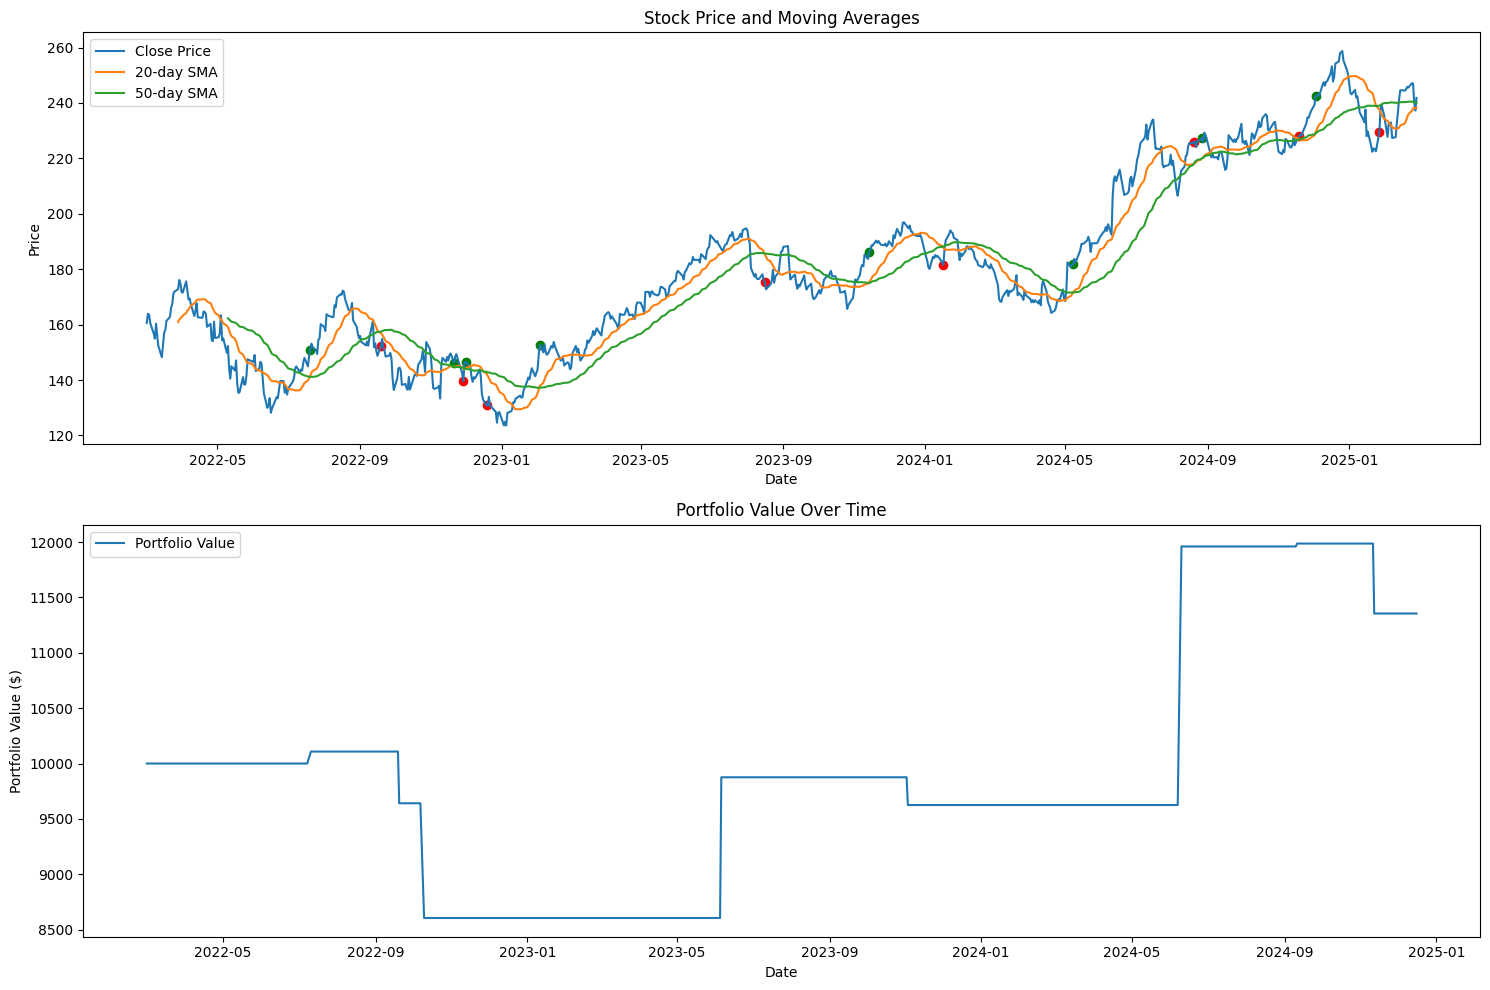


Strategy Performance:
Initial Capital: $10000.00
Final Portfolio Value: $11355.03
Total Return: 13.55%
Annualized Return: 4.53%
Number of Trades: 16

Stock Trading Strategy Analyzer


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

class StockAnalyzer:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital

    def fetch_stock_data(self, symbol, start_date, end_date):
        """Fetch historical stock data with comprehensive analysis."""
        try:
            data = yf.download(symbol, start=start_date, end=end_date)

            if data.empty:
                print(f"No data available for {symbol} in the specified date range.")
                return None

            # Calculate key technical indicators
            data['Returns'] = data['Close'].pct_change()
            data['Cumulative_Returns'] = (1 + data['Returns']).cumprod() - 1

            # Moving Averages
            data['SMA_20'] = data['Close'].rolling(window=20).mean()
            data['SMA_50'] = data['Close'].rolling(window=50).mean()

            # Relative Strength Index (RSI)
            delta = data['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)  # Prevent division by zero
            data['RSI'] = 100 - (100 / (1 + rs))

            return data

        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def backtest_strategy(self, data, strategy='simple_moving_average'):
        """Backtest different trading strategies with improved error handling."""
        if data is None or len(data) == 0:
            print("No data available for backtesting.")
            return None

        # Initialize trading variables
        portfolio_value = self.initial_capital
        shares = 0
        trades = []
        portfolio_values = [self.initial_capital]

        # Ensure we have enough data for strategy calculations
        if len(data) < 50:
            print("Insufficient data for backtesting.")
            return None

        if strategy == 'simple_moving_average':
            for i in range(50, len(data)):  # Start after 50-day moving average is valid
                sma_20 = float(data['SMA_20'].iloc[i])
                sma_50 = float(data['SMA_50'].iloc[i])
                close_price = float(data['Close'].iloc[i])

                # Buy signal
                if sma_20 > sma_50 and shares == 0:
                    shares = portfolio_value / close_price
                    portfolio_value = shares * close_price
                    trades.append(('Buy', data.index[i], close_price))

                # Sell signal
                elif sma_20 < sma_50 and shares > 0:
                    portfolio_value = shares * close_price
                    trades.append(('Sell', data.index[i], close_price))
                    shares = 0

                # Track portfolio value
                portfolio_values.append(portfolio_value)

        elif strategy == 'rsi_strategy':
            for i in range(14, len(data)):  # Start after RSI calculation
                rsi = float(data['RSI'].iloc[i])
                close_price = float(data['Close'].iloc[i])

                # Buy signal (oversold)
                if rsi < 30 and shares == 0:
                    shares = portfolio_value / close_price
                    portfolio_value = shares * close_price
                    trades.append(('Buy', data.index[i], close_price))

                # Sell signal (overbought)
                elif rsi > 70 and shares > 0:
                    portfolio_value = shares * close_price
                    trades.append(('Sell', data.index[i], close_price))
                    shares = 0

                # Track portfolio value
                portfolio_values.append(portfolio_value)

        # Final portfolio value calculation
        final_portfolio_value = portfolio_value

        # Calculate performance metrics
        total_return = (final_portfolio_value - self.initial_capital) / self.initial_capital * 100
        annual_return = total_return * (252 / len(data))  # Annualize return

        return {
            'trades': trades,
            'portfolio_values': portfolio_values,
            'total_return': total_return,
            'annual_return': annual_return,
            'final_portfolio_value': final_portfolio_value
        }

    def visualize_results(self, data, backtest_results):
        """Visualize stock performance and trading strategy results."""
        if data is None or backtest_results is None:
            print("No data available for visualization.")
            return

        plt.figure(figsize=(15, 10))

        # Stock Price and Moving Averages
        plt.subplot(2, 1, 1)
        plt.plot(data.index, data['Close'], label='Close Price')
        plt.plot(data.index, data['SMA_20'], label='20-day SMA')
        plt.plot(data.index, data['SMA_50'], label='50-day SMA')

        # Plot trades
        for trade in backtest_results['trades']:
            color = 'green' if trade[0] == 'Buy' else 'red'
            plt.scatter(trade[1], trade[2], color=color, marker='o')

        plt.title('Stock Price and Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        # Portfolio Value Over Time
        plt.subplot(2, 1, 2)
        plt.plot(data.index[:len(backtest_results['portfolio_values'])],
                 backtest_results['portfolio_values'], label='Portfolio Value')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("\nStrategy Performance:")
        print(f"Initial Capital: ${self.initial_capital:.2f}")
        print(f"Final Portfolio Value: ${backtest_results['final_portfolio_value']:.2f}")
        print(f"Total Return: {backtest_results['total_return']:.2f}%")
        print(f"Annualized Return: {backtest_results['annual_return']:.2f}%")
        print(f"Number of Trades: {len(backtest_results['trades'])}")

def main():
    while True:
        print("\nStock Trading Strategy Analyzer")

        symbol = input("Enter stock symbol (e.g., AAPL): ").upper()

        while True:
            start_date = input("Enter start date (YYYY-MM-DD): ")
            end_date = input("Enter end date (YYYY-MM-DD): ")

            try:
                datetime.strptime(start_date, '%Y-%m-%d')
                datetime.strptime(end_date, '%Y-%m-%d')
                break
            except ValueError:
                print("Invalid date format. Please use YYYY-MM-DD.")

        print("\nSelect Strategy:")
        print("1. Simple Moving Average Crossover")
        print("2. RSI (Relative Strength Index)")

        strategy_choice = input("Enter strategy number (1/2): ")

        strategy_map = {
            '1': 'simple_moving_average',
            '2': 'rsi_strategy'
        }

        analyzer = StockAnalyzer(initial_capital=10000)

        stock_data = analyzer.fetch_stock_data(symbol, start_date, end_date)

        if stock_data is not None:
            backtest_results = analyzer.backtest_strategy(
                stock_data,
                strategy_map.get(strategy_choice)
            )

            if backtest_results:
                analyzer.visualize_results(stock_data, backtest_results)

if __name__ == "__main__":
    main()
